In [318]:
#load aiida environment and connect to database
from aiida import load_profile
from aiida.orm import computers
profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [420]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData 
from aiida.orm import (Group, load_group, load_node, load_code, groups,
                      WorkChainNode, QueryBuilder, CalcJobNode)
from aiida.engine import submit
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import (kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, combine_imps_wc,
                                 kkr_flex_wc)
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username

In [320]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals
from builtins import object, str
from six.moves import range
from six.moves import input
from masci_tools.io.common_functions import open_general
from masci_tools.io.common_functions import search_string
import numpy as np
from masci_tools.io.common_functions import get_alat_from_bravais
from masci_tools.io.common_functions import vec_to_angles
from aiida.common.constants import elements as PeriodicTableElements
_atomic_numbers = {data['symbol']:num for num,
                data in PeriodicTableElements.items()}
load_stuc = load_node(234)
load_stuc

<StructureData: uuid: c1626804-5b71-450c-91c4-aa7197d85279 (pk: 234)>

In [150]:
node_16215 = load_node(16215)
node_16100 = load_node(16100)
# node_16215.outputs.
# node_16100.outputs.workflow_info.pk

SyntaxError: invalid syntax (<ipython-input-150-9dca4e44ca7d>, line 3)

In [ ]:
# imp_dos_group = load_group(72)

plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[2:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

In [ ]:
# imp_dos_group = load_group(72)

plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[2:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
#     # highlight the contibution of the impurity (iatom=0)
#     plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
#              noshow=True, nofig=True, color='C'+str(i),
#              lw=3, iatom=0, 
#             )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

No handles with labels found to put in legend.


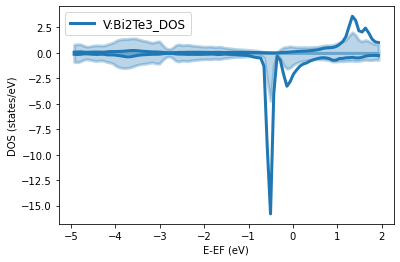

In [138]:
plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[3:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

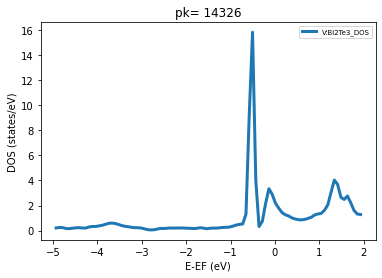

In [139]:
 plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0,all_atoms= False, sum_spins= True,)

In [140]:
#imp_kkr_wc = 10085
imp_out = load_node(11948)
# kkrimp_calc = imp_out.outputs.last_calc_output_parameters.get_incoming(KkrimpCalculation).all()
# imp_info = imp_out.outputs.workflow_info.get_incoming(link_label_filter='workflow_info').all()
# # print(imp_info[0].node)
# print(kkrimp_calc[0].node)
ldau_test = imp_out.outputs.workflow_info.get_dict()
# ldau_test

In [274]:
kkr = None
if kkr == None:
    print('ok')

ok


In [261]:
####### NOTE: If this csucessful then please add it into the 'tools_development' ipynb
## In this part the node has been collected to store in new group only considering the kkr_imp_wc node
group_wasmer = load_group(83)
# node_label
debug= False
wasmer_grp_list = list(group_wasmer.nodes)
group_label = 'imp_embedded_Au_by_wasmer'
try:
    new_grp = load_group(node_label)
    print('Group as named %s is already stored, so no need to create the group'%(node_label))
except:
    new_grp = Group(label=group_label)
    new_grp.store()
    print(' A new node created as named %s' %node_label)
new_grp_list = list(new_grp.nodes)
i=0
imp_wc_no = 0
for index in range(len(wasmer_grp_list)):
    node = wasmer_grp_list[index]
    if node.node_type.split('.')[-2]=='WorkChainNode':
        if (u'kkr_imp_wc' == node.process_label):
            imp_wc_no += 1
            if node in new_grp_list[:]:
                print('node {} is already exist'.format(node.pk))
            else:
                new_grp.add_nodes(node)
            if debug:
                print(node.process_label)
                print('pk: %7d'%node.pk)
                print(wasmer_grp_list[i])
                print(node.label)
                
                        
        

print(imp_wc_no)

Group as named imp_embedded_Au_by_wasmer is already stored, so no need to create the group
39


In [106]:
# This is for kkrimpcalc step-1
[['NSPIN', 2], ['HFIELD', [0.0, 0]], ['INS', 1], ['NCOLL', 1], ['SPINORBIT', 1], ['SCFSTEPS', 100], ['IMIX', 0], ['MIXFAC', 0.001], ['QBOUND', 0.008], ['TESTFLAG', ['tmatnew']], ['CALCORBITALMOMENT', 1]]
[['NSPIN', 2], ['HFIELD', [0.02, 5]], ['INS', 1], ['NCOLL', 1], ['SPINORBIT', 1], ['SCFSTEPS', 300], ['IMIX', 0], ['MIXFAC', 0.02], ['QBOUND', 0.05], ['TESTFLAG', ['tmatnew']], ['CALCORBITALMOMENT', 1]]
# This is for kkrimpcalc step-2
[['NSPIN', 2], ['HFIELD', [0.0, 0]], ['INS', 1], ['NCOLL', 1], ['SPINORBIT', 1], ['SCFSTEPS', 100], ['IMIX', 5], ['MIXFAC', 0.008], ['ITDBRY', 60], ['QBOUND', 1e-07], ['NSIMPLEMIXFIRST', 0], ['TESTFLAG', ['tmatnew']], ['CALCORBITALMOMENT', 1]]
[['NSPIN', 2], ['HFIELD', [0.0, 0]], ['INS', 1], ['NCOLL', 1], ['SPINORBIT', 1], ['SCFSTEPS', 300], ['IMIX', 5], ['MIXFAC', 0.05], ['ITDBRY', 20], ['QBOUND', 1e-07], ['NSIMPLEMIXFIRST', 0], ['TESTFLAG', ['tmatnew']], ['CALCORBITALMOMENT', 1]]

[['NSPIN', 2],
 ['HFIELD', [0.0, 0]],
 ['INS', 1],
 ['NCOLL', 1],
 ['SPINORBIT', 1],
 ['SCFSTEPS', 100],
 ['IMIX', 5],
 ['MIXFAC', 0.008],
 ['ITDBRY', 60],
 ['QBOUND', 1e-07],
 ['NSIMPLEMIXFIRST', 0],
 ['TESTFLAG', ['tmatnew']],
 ['CALCORBITALMOMENT', 1]]

In [426]:
## DOS group:
ilayer_3 = list(load_group(94).nodes)
ilayer_4 = list(load_group(93).nodes)
ilayer_3 = [i.pk for i in ilayer_3[:]]
ilayer_4 = [i.pk for i in ilayer_4[:]]
ilayer_3_4 = zip(ilayer_3, ilayer_4)
list(ilayer_3_4)


[(22896, 21270),
 (22907, 21312),
 (22910, 21316),
 (22913, 21321),
 (22916, 21325),
 (22919, 21330),
 (22922, 21335),
 (22925, 21341),
 (22928, 21345),
 (22933, 21350),
 (22938, 21354),
 (22942, 21359),
 (22947, 21362),
 (22953, 21368),
 (22956, 21373),
 (22962, 21377),
 (22966, 21382),
 (22971, 21386),
 (22975, 21391)]

In [439]:
node_16346 = load_node(23784)
node_16346.outputs.workflow_info.get_dict()['sub_workflows']

{'host_gf': {'pk': 23790, 'uuid': '96779c30-20b2-42dd-92ce-47ce6a3de15f'},
 'kkrimp_scf': {'pk': 23823, 'uuid': '7feebdb4-c22a-427b-b362-52a5ffa537f1'}}

In [447]:
group = load_group(74)
nodes = list(group.nodes)
node_0 = nodes[6]
node_0.outputs.last_calc_output_parameters.get_dict()

{'nspin': 2,
 'energy': -1146606.063365,
 'energy_unit': 'eV',
 'fermi_energy': 0.4991457961,
 'timings_unit': 'seconds',
 'use_newsosol': True,
 'parser_errors': [],
 'timings_group': {'energyloop': 112.67565598599,
  'gref->gmat': 0.095751163311476,
  'Iteration number': 113.79086481139,
  'gonsite->density': 4.9118488333946,
  'Total running time': 4897.1870117188,
  'time until scf starts': 4.1571002006531},
 'parser_version': '0.4.2',
 'warnings_group': {'warnings_list': [], 'number_of_warnings': 0},
 'code_info_group': {'code_version': 'v3.1-1679-g1fae947',
  'compile_options': 'intel',
  'calculation_serial_number': '20210226231412'},
 'magnetism_group': {'spin_moment_unit': 'mu_Bohr',
  'total_spin_moment': 2.393026,
  'orbital_moment_unit': 'mu_Bohr',
  'spin_moment_per_atom': [[-9.6544141671731e-05,
    -2.1655082055001e-05,
    2.1030878357754],
   [1.5944717871802e-05, -0.00074783690545368, 0.00096400614726311],
   [-0.0004297700310155, -0.00026035093870531, 0.0014417580271

In [ ]:
outputs